## Scalar wave equation in 1D

This example describes a wave equation moving along a flow with a constant velocity. The (non-dimensional) equation we are solving is a linear convection equation in 1D
$$
\partial_t u + b \partial_x u = 0, \qquad \forall\, x \in \Omega = [-2,+2], \quad t \in [0, 12],
$$
where the wind velocity is $b = 1.0$. 

The exact solution to this PDE, known as d'Alembert's solution, is a simple shift of the initial condition along the velocity. In other words, for an initial solution $u(x,t_0) = f(x)$, the exact solution at any given moment is $u(x,t) = f(x - bt)$. We choose a Gaussian profile to express the solution, with the following form
$$
u(x,t) = \frac{1}{\sigma\sqrt{\pi}} e^{-r^2/(2 \sigma^2)},
$$
where the standard deviation is $\sigma = 0.15$ and the (time-dependent) radial distance is $r^2 = (x(t) - x_0)^2$, with $x(t) = x - b t$ denoting the moving frame of reference and $x_0 = 0$ is the initial pulse location at $t = t_0$. Of course, the initial solution is simply $u(x, 0)$.

In [1]:
# Import preliminary modules.
from dream import *
from dream.scalar_transport import Initial, transportfields, ScalarTransportSolver
from ngsolve import *
from ngsolve.meshes import Make1DMesh
from matplotlib import pyplot as plt 

In [2]:
# Generate the grid.
ne =  20
x0 = -2.0 
x1 =  2.0
lx =  x1 - x0

# Generate a simple grid.
mesh = Make1DMesh(ne, periodic=True, mapping=lambda x: lx*x + x0 )

# Message output detail from netgen.
ngs.ngsglobals.msg_level = 0 
ngs.SetNumThreads(4)

In [3]:
# Define the analytic solution.
def get_analytic_solution(t, v): 

    # Initial pulse location.
    x0 = 0.0 
    # Variance.
    s2 = 0.0225
    
    # Pulse center.
    xt = ngs.x - v*t 
    # Number of cycle throughout the simulation.
    n_cycle = 4 
    
    # Main function.
    f = ngs.exp( -(xt-x0)**2/(2.0*s2) )/( sqrt(s2*ngs.pi) )
    
    # Cycles of this function (lagging by lx, assuming v>0).
    for i in range(1,n_cycle):
        x0t = x0 - i*lx
        f += ngs.exp( -(xt - x0t)**2/(2.0*s2) )/( sqrt(s2*ngs.pi) )
    return f 


In [4]:
# Solver configuration: pure convection equation.
cfg = ScalarTransportSolver(mesh)

cfg.convection_velocity = (1.0,)
cfg.is_inviscid = True

cfg.riemann_solver = "lax_friedrich"
cfg.fem = "dg" # NOTE, by default, DG is used.
cfg.fem.order = 0

cfg.time = "transient"
cfg.fem.scheme = "implicit_euler"
cfg.time.timer.interval = (0.0, 12.0)
cfg.time.timer.step = 0.01

cfg.linear_solver = "pardiso"
cfg.optimizations.static_condensation = False  # NOTE, by default, condensation is turned off.
cfg.optimizations.compile.realcompile = False

U0 = transportfields()
U0.phi = get_analytic_solution(cfg.time.timer.interval[0], cfg.convection_velocity[0])

cfg.bcs['left|right'] = "periodic"
cfg.dcs['dom'] = Initial(fields=U0)


In [5]:
# Decorator for the actual simulation.
import numpy as np  

# Extract time configuration.
t0, tf = cfg.time.timer.interval
dt = cfg.time.timer.step.Get()
nt = int(round((tf - t0) / dt))

# Define a decorator for the wave equation routine.
def wave1d_routine(label):
    def decorator(func):
        def wrapper(*args, **kwargs):

            # By default, assume this is a DG formulation.
            cfg.optimizations.static_condensation = False

            # Insert options here.
            func(*args, **kwargs)
            cfg.fem.order = 5

            # In case an HDG formulation is specified, use static condensation.
            if cfg.fem.name == "hdg":
                cfg.optimizations.static_condensation = True
            
            # Allocate the necessary data.
            cfg.initialize()

            # Get a reference to the numerical solution and the analytic solution.
            uh = cfg.fem.get_fields("phi").phi
            ue_func = get_analytic_solution(cfg.time.timer.t, cfg.convection_velocity[0])

            # Generate a local mesh here, since it depends on the polynomial order.
            xcoor = np.linspace(x0, x1, ne * cfg.fem.order, dtype=float)

            # Integration order (for post-processing).
            qorder = 10

            # Data for book-keeping information.
            data = np.zeros((nt, 2), dtype=float)


            # Time integration loop (actual simulation).
            for i, t in enumerate(cfg.time.start_solution_routine(True)):
                
                # Compute the L2-norm of the error.
                err = np.sqrt(ngs.Integrate((ue_func - uh) ** 2, mesh, order=qorder))

                # Store data: time and error metrics.
                data[i] = [cfg.time.timer.t.Get(), err]

            # Evaluate the solution at final time.
            u_final = uh(mesh(xcoor))
            return data, xcoor, u_final
        wrapper.label = label
        return wrapper
    return decorator

In [6]:
# Specialized simulation routines.
@wave1d_routine("implicit_euler(hdg)")
def implicit_euler_hdg():
    cfg.fem = "hdg"
    cfg.fem.scheme = "implicit_euler"
    
@wave1d_routine("implicit_euler(dg)")
def implicit_euler_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "implicit_euler"

@wave1d_routine("bdf2(hdg)")
def bdf2_hdg():
    cfg.fem = "hdg"
    cfg.fem.scheme = "bdf2"
@wave1d_routine("bdf2(dg)")
def bdf2_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "bdf2"

@wave1d_routine("sdirk22(hdg)")
def sdirk22_hdg():
    cfg.fem = "hdg"
    cfg.fem.scheme = "sdirk22"
@wave1d_routine("sdirk22(dg)")
def sdirk22_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "sdirk22"

@wave1d_routine("sdirk33(hdg)")
def sdirk33_hdg():
    cfg.fem = "hdg"
    cfg.fem.scheme = "sdirk33"
@wave1d_routine("sdirk33(dg)")
def sdirk33_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "sdirk33"

@wave1d_routine("imex_rk_ars443(dg)")
def imex_rk_ars443_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "imex_rk_ars443"

@wave1d_routine("ssprk3(dg)")
def ssprk3_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "ssprk3"

@wave1d_routine("crk4(dg)")
def crk4_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "crk4"

@wave1d_routine("explicit_euler(dg)")
def explicit_euler_dg():
    cfg.fem = "dg"
    cfg.fem.scheme = "explicit_euler"


In [7]:
# Figure style and properties.

# Assign colors to base method names
method_colors = {
    "implicit_euler": "tab:red",
    "bdf2": "tab:blue",
    "sdirk22": "tab:green",
    "sdirk33": "tab:purple"
}

# Helper function that sets up a generic figure.
def setup_fig(xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.grid(True)
    return fig,ax

# Helper function that specifies the plot style properties.
def get_plot_style(label, method_colors):
    if label.endswith("(hdg)"):
        base_name = label.replace("(hdg)", "").strip()
        linestyle = "-"
        marker = 'o'
    elif label.endswith("(dg)"):
        base_name = label.replace("(dg)", "").strip()
        linestyle = "--"
        marker = '^'
    else:
        base_name = label.strip()
        linestyle = ":"
        marker = '.'

    color = method_colors.get(base_name, "black")

    return {
        "label": label,
        "linestyle": linestyle,
        "marker": marker,
        "markersize": 8,
        "markevery": 50,
        "color": color
    }

Running implicit_euler(hdg)...


Running implicit_euler(dg)...


Running bdf2(hdg)...


Running bdf2(dg)...


Running sdirk22(hdg)...


Running sdirk22(dg)...


Running sdirk33(hdg)...


Running sdirk33(dg)...


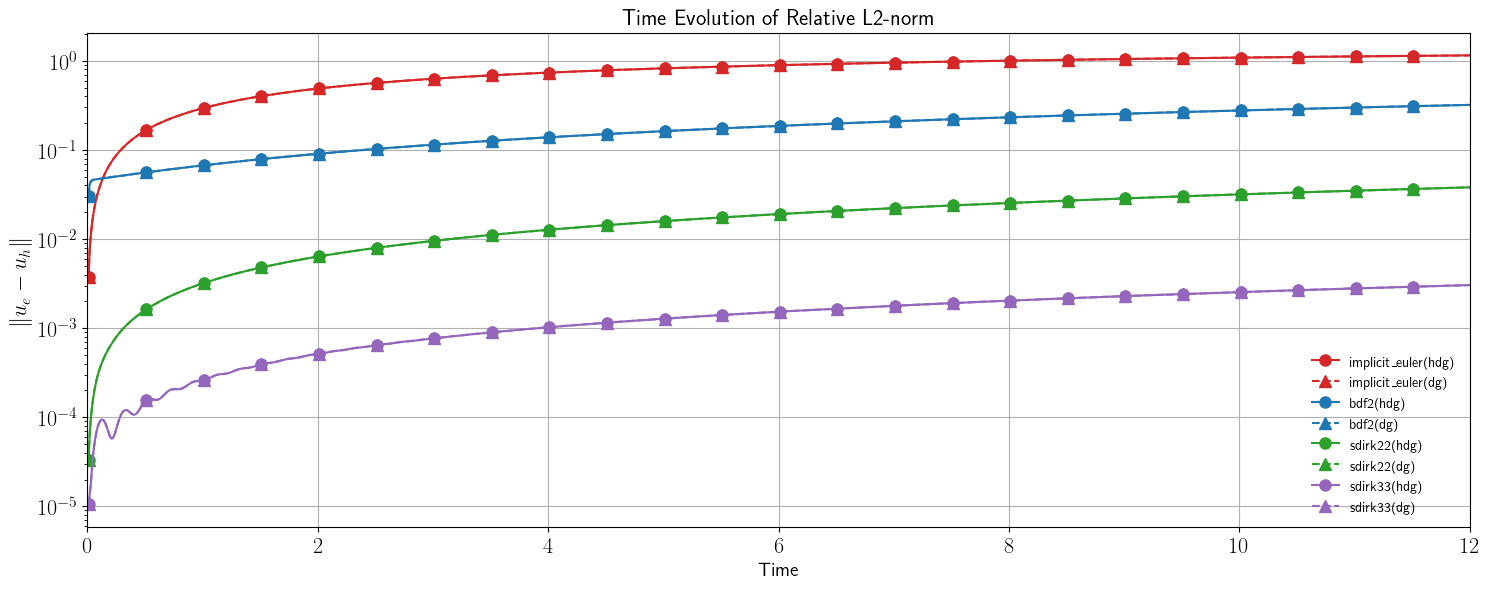

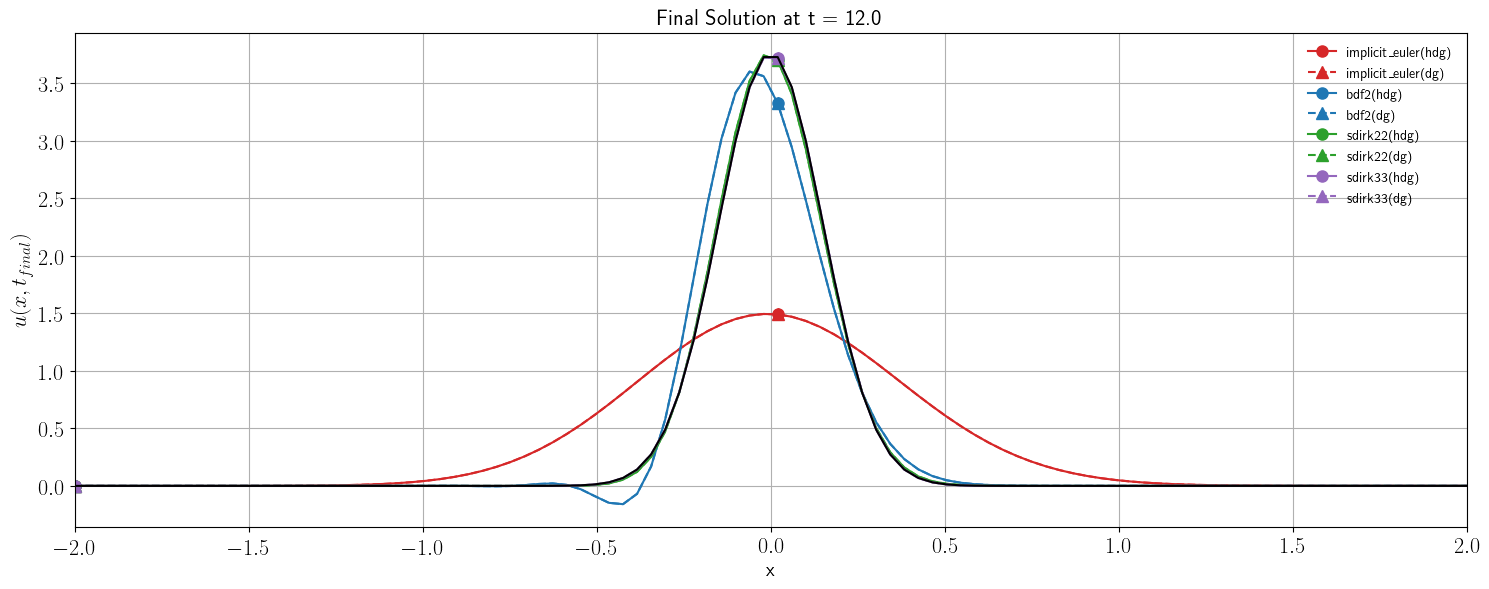

In [8]:
# Run simulation(s).
routines = [implicit_euler_hdg, implicit_euler_dg,
                      bdf2_hdg,           bdf2_dg,
                   sdirk22_hdg,        sdirk22_dg,
                   sdirk33_hdg,        sdirk33_dg]

plt.ioff()

# Figure 1: logaraithmic plot of the relative error in the L2-norm.
fig1, ax1 = setup_fig("Time", r"$\| u_e - u_h \|$", "Time Evolution of Relative L2-norm")

# Figure 2: instantaneous solution at the final time step.
fig2, ax2 = setup_fig("x", r"$u(x, t_{final})$", f"Final Solution at t = {tf}")

# Run each simulation.
for routine in routines:
    print(f"Running {routine.label}...")
    data, xcoor, usol = routine()
    style = get_plot_style(routine.label, method_colors)

    ax1.semilogy(data[:, 0], data[:, 1], **style)
    ax2.plot(xcoor, usol, **style)

# Plot analytic solution at the final step.
ue_final = get_analytic_solution(t0, cfg.convection_velocity[0])
ax2.plot(xcoor, ue_final(mesh(xcoor)), 'k-')

# Final touches.
ax1.legend(loc="lower right", frameon=False)
ax2.legend(loc="upper right", frameon=False)
ax1.set_xlim(t0, tf)
ax2.set_xlim(x0, x1)
fig1.tight_layout()
fig2.tight_layout()

# Let's see our masterpiece..
plt.show()